# **Inference Step Result Visualization**

The previously analyzed data is here used to visualize the results in various figures. Individual models (and comparisons between up to three models) can be visualized in barplots for each tracked parameter, while all considered models are shown through line-plots.

In [216]:
# import required libraries
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glasbey
import glob
import os
import re

In [ ]:
# get working directory, necessary to gather the data to be analyzed
current_dir = os.getcwd()
print(f"Current Working Directory: {current_dir}")
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(f"Parent Directory: {parent_dir}")

## **Helper Functions**
Useful functions to properly format labels and visualize plots correctly.

In [218]:
def get_individual_plot(path, diffmodel, runs=5, size=(10, 6), fontdim=16, option="summary"):
    """
    Plots analyzes CodeCarbon logs of emission experiment results for diffusion models.

    Processes mean and standard deviation for energy and emissions metrics,
    visualizing them in plots for each tracked parameter.

    Parameters:
    -----------
    path : list[str]
        List of file paths to CodeCarbon log CSV files for the experiment.
        Each path should point to a CSV file containing emission metrics.

    diffmodel : str
        Name of the model being analyzed. Used for labeling output files and results.

    runs : int, optional (default=5)
        Number of experimental runs to process.
        Recommendation: Use at least 10 runs to reduce statistical variability.
        If more paths are provided than runs, only the first 'runs' will be processed.

    size : tuple, optional (default=(10, 6))
        Dimensions of generated plots in inches (width, height).

    fontdim : int, optional (default=16)
        Font size for plot annotations and labels.

    plot : bool, optional (default=True)
        Flag to generate and save visualization plots.

    option : str, optional (default="summary")
        Specifies the type of metrics to analyze and output.
        Valid options include:

        - "power": Component power consumption
        - "energy": Energy consumption per component
        - "gpu_energy":  Energy consumed by the models (main computations, performed on GPU)
        - "energy_consumed": Total energy used
        - "emissions": Carbon emissions
        - "emissions_rate": Emission rate
        - "summary": Overview of all metrics

    Returns:
    --------
    None
        Outputs are written to PDF files
    """

    # Initialize the summary flag to False. This controls whether a comprehensive summary
    # of all metrics is generated or if the analysis focuses on a specific metric option.
    summary = False
    # Dictionary mapping emission metrics to their visualization and labeling properties
    # Each entry contains: [column_name, color_set, display_title, unit, description]
    emissdict = {"power": ["power_type", "Set1", "Component Power", "[W]", "Component power"],
                 "energy": ["energy_type", "Set1", "Component consumption", "[kWh]",
                            "Energy used by components"],
                 "gpu_energy": ["gpu_energy", "rocket_r", "Energy at inference (GPU)", "[kWh]", "Energy at inference (GPU)"],
                 "energy_consumed": ["energy_consumed", "rocket_r", "Total energy used", "[kWh]", "Energy Used"],
                 "emissions": ["emissions", "crest", "Emissions", "[$CO_2$eq]", "Emissions in $CO_2$-eq"],
                 "emissions_rate": ["emissions_rate", "crest", "Emission Rate", "[Kg/s]",
                                    "Emission rate"]}

    # Aggregate data from multiple experimental runs
    all_data = []
    for i, file_path in enumerate(path):
        if i >= runs:
            break
        df = pd.read_csv(file_path)
        all_data.append(df)
    # Concatenate data from all runs into a single dataframe
    dfr = pd.concat(all_data, ignore_index=True)
    # Extract number of inference steps from project name
    dfr['project_name'] = dfr['project_name'].apply(lambda k: re.search(r'(\d+)-steps', k).group(1))

    # Iterate through different emission metric options
    for i, en in enumerate(emissdict.keys()):
        df = dfr
        # Prepare mean and standard deviation DataFrames
        column_names = df.columns[5:14]
        df["project_name"] = pd.to_numeric(df["project_name"], errors='coerce')
        # Calculate mean and standard deviation
        deviations = (df.groupby("project_name")[column_names].std()
                      .sort_values(by='project_name', ascending=True).reset_index())
        df = (df.groupby("project_name")[column_names].mean()
              .sort_values(by='project_name', ascending=True).reset_index())
        # Convert project names to strings
        df["project_name"] = df["project_name"].astype(str)
        deviations["project_name"] = deviations["project_name"].astype(str)

        # Handle the summary option: save complete mean and standard deviation files
        if option == "summary":
            summary = True

        # Skip iterations if not in summary mode and not first iteration
        if not summary and i != 0:
            continue
        elif summary:
            option = en

        # Handling for power and energy metrics (group values for the same inference steps)
        if option in ("power", "energy"):
            df = melt_and_map(df, option)
            deviations = melt_and_map(deviations, option)

        # Generate visualization
        stds = deviations[f"{option}"].values.flatten()
        plt.figure(figsize=(size[0], size[1]))
        sns.set_theme(style="whitegrid")
        font_path = current_dir + r"\Times-Roman Regular.ttf"
        font_manager.fontManager.addfont(font_path)
        prop = font_manager.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = prop.get_name()
        plt.rcParams['legend.title_fontsize'] = fontdim
        plt.grid(axis='y', linestyle='--', linewidth=1.5, zorder=0)
        ax = sns.barplot(data=df, x='project_name', y=df[f"{option}"], hue=emissdict[option][0],
                         palette=emissdict[option][1], errorbar=None, zorder=2)

        for idx, patch in enumerate(ax.patches):
            if idx >= len(stds):  # Prevent indexing errors
                break
            height = patch.get_height()
            x_position = patch.get_x() + patch.get_width() / 2
            error_value = stds[idx]

            # Ensure the error bar doesn't go below zero
            lower_limit = max(0, height - error_value)
            upper_limit = height + error_value

            ax.errorbar(
                x=x_position,
                y=height,
                yerr=[[height - lower_limit], [upper_limit - height]],  # Asymmetric error bars
                fmt='none',
                color='gray',
                capsize=5,
                elinewidth=2.5,
                zorder=3
            )

        plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        plt.gca().yaxis.get_offset_text().set_fontname("Times New Roman")
        plt.gca().yaxis.get_offset_text().set_fontsize(15)
        plt.xlabel('Number of inference steps', fontsize=fontdim + 10)
        plt.ylabel(f'{emissdict[option][4]} {emissdict[option][3]}', fontsize=fontdim + 10)
        plt.yticks(fontsize=fontdim + 4)
        plt.xticks(fontsize=fontdim + 4)
        plt.title(f'{diffmodel} Inference - {emissdict[option][2]}', fontsize=fontdim + 10)

        handles, labels = plt.gca().get_legend_handles_labels()
        labels = [format_label(label, decimals=8) for label in labels]
        plt.legend(handles, labels, title=f'', fontsize=fontdim-3).set_zorder(5)
        if option in ("power", "energy"): plt.tight_layout();  plt.legend(title="Component", fontsize=fontdim-3)
        plt.savefig(current_dir + fr"\figures\inference_steps\individual_plots\{diffmodel}\{option}-barplot.pdf", dpi=300, bbox_inches='tight')
        plt.show()

In [219]:
def melt_and_map(df, option):
    """
    Transforms a DataFrame by reshaping and labeling component-specific energy or power metrics.
    - Reshapes the DataFrame from wide to long format, focusing on CPU, GPU, and RAM metrics
    - Replaces generic column names with component descriptions

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing component-specific metrics. Expected to have columns for CPU, GPU, and RAM metrics.

    option : str
        The type of metric being processed. Either "power" or "energy".

    Returns:
    --------
    pandas.DataFrame
        Reshaped and relabeled DataFrame with the following changes:
        - Converted from wide to long format
        - Component columns renamed to specific hardware descriptions
        - Maintains the original project name as an identifier
    """
    # Reshape the DataFrame from wide to long format, focusing on component-specific metrics
    df = pd.melt(df, id_vars=["project_name"],
                 value_vars=[f"cpu_{option}", f"gpu_{option}", f"ram_{option}"],
                 var_name=f"{option}_type", value_name=f"{option}")

    # Map generic column names to specific hardware component descriptions
    df[f"{option}_type"] = df[f"{option}_type"].map({
        f"cpu_{option}": "CPU (AMD EPYC 7313)",
        f"gpu_{option}": "GPU (NVIDIA A40)",
        f"ram_{option}": "RAM (64 GB)"
    })
    return df

In [220]:
def format_powen(df, emissdict, option):
    """
    Formats DataFrame of performance metrics with sorted project names and units appended to numeric values.
    Works with either "energy" or "power" options.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing performance and energy metrics.
        Expected to have columns 'project_name' and metric-specific columns.

    emissdict : dict
        Dictionary mapping metric options to specific configuration details.

    option : str
        Specifies the type of metric to be formatted. Must be a valid key in emissdict.

    Returns:
    --------
    pandas.DataFrame
        Formatted DataFrame with:

        - Rows sorted by numeric project identifier
        - Columns: 'Inference steps', 'CPU', 'GPU', 'RAM'
        - Numeric values with appropriate units
    """
    # Pivot the DataFrame to structure it with 'project_name' as rows and a metric as columns
    df_pivot = df.pivot(index="project_name", columns=emissdict[option][0], values=f"{option}").reset_index()
    # Sort the DataFrame by extracting numeric identifiers from the 'project_name' column
    df_pivot = df_pivot.loc[
        df_pivot['project_name'].str.extract(r'(\d+)').astype(int).squeeze().sort_values().index]
    # Rename columns
    df_pivot.columns = ['Inference steps', 'CPU', 'GPU', 'RAM']
    # Append units to numeric values in 'CPU', 'GPU', and 'RAM' columns
    for col in ['CPU', 'GPU', 'RAM']:
        df_pivot[col] = df_pivot[col].astype(str) + f" {emissdict[option][3]}"
    return df_pivot

In [221]:
def format_label(label, decimals):
    """
    Formats a numeric label to a specified number of decimal places.
    Uses scientific notation for very small values and standard decimal format otherwise.

    Parameters:
    -----------
    label : str or numeric
        The value to be formatted. If not a valid numeric value, it is returned unchanged.

    decimals : int
        Number of decimal places for formatting the numeric label.

    Returns:
    --------
    str
        Formatted label as a string:

        - Values smaller than 0.0001 are represented in scientific notation.
        - Larger values are formatted with the specified number of decimal places.
        - Non-numeric labels are returned as-is.
    """
    try:
        # Check if the label is very small
        if float(label) < 0.01:
            # Use scientific notation with a reduced number of decimals
            label = f"{float(label):.{decimals - 3}e}"
            # Format label to general floating-point format (more compact)
            return f"{float(label):.{decimals - 3}g}"
        else:
            # Format as a decimal string with specified precision
            label = f"{float(label):.{decimals}f}"
            return f"{float(label):.{decimals}g}"
    except ValueError:
        return label

## **Analyze data**
Using the previously defined functions, we now can analyze the data obtained for the five different runs for all considered models.

In [222]:
def compare_models(pathfile, models, dctcolors, option="summary"):
    """
    Compare emission experiment results from multiple.

    Processes emission data from CodeCarbon logs and produces comparative plots
    for energy consumption, emissions, or emission rate metrics. Results are
    saved as PNG files in the specified directory.

    Parameters:
    -----------
    pathfile : list[list[str]]
        Nested list of file paths to the analyzed run logs in CSV format.
        Each inner list corresponds to a specific model and should include
        paths for mean and standard deviation data.

    models : list[str]
        Names of the models being compared, used for labeling the plots.

    dctcolors : dict
        Dictionary containing the names of the models and their respective colors in the generated palette.

    option : str, optional (default="summary")
        Metric to visualize. Allowed values:

        - "gpu_energy": Energy consumed by the models (main computations, performed on GPU).
        - "emissions": Total emissions (in CO₂-equivalents).
        - "emissions_rate": Emission rate during experiments.
        - "summary": Generate plots for all metrics.

    Returns:
    --------
    None
        The function saves the plots as PDF files and displays them.
    """
    # Initialize the summary flag to control metric analysis
    summary = False
    fontdim = 16; out = "pdf"
    size = (10, 5)
    # Mapping emission metrics to their attributes for plotting and labeling
    emissdict = {"gpu_energy": ["gpu_energy", "rocket_r", "Energy at inference", "[kWh]", "Energy at inference"],
                 "emissions": ["emissions", "crest", "Emissions", "[Kg]",
                               "Emissions in $CO_2$-eq"],
                 "emissions_rate": ["emissions_rate", "crest", "Emission Rate", "[Kg/s]",
                                    "Emission rate"]}

    # Separate mean and standard deviation data for all models
    all_data = [[], []]  # [mean data, std data]
    for p in pathfile:
        for file_path in p:
            df = pd.read_csv(file_path)
            if file_path.endswith("mean.csv"): all_data[0].append(df)
            else: all_data[1].append(df)
    # Combine all mean and standard deviation data into respective DataFrames
    df_mean = pd.concat(all_data[0], ignore_index=True)
    df_std = pd.concat(all_data[1], ignore_index=True)
    # Assign model names to the corresponding rows in DataFrames (needed for plotting)
    for k, modello in enumerate(models):
        df_mean.loc[k * 6:(k * 6) + 5, "model"] = modello
        df_std.loc[k * 6:(k * 6) + 5, "model"] = modello

    # Iterate through emission metrics for visualization
    for i, p in enumerate(emissdict.keys()):

        if option == "summary":
            summary = True
        # Skip metrics if not in summary mode
        if not summary and i != 0:
            continue
        elif summary:
            option = p

            # Extract standard deviations for error bars
            stds = df_std[f"{option}"].values.flatten()

            plt.figure(figsize=(size[0], size[1]))
            sns.set_theme(style="whitegrid")
            font_path = current_dir + r"\Times-Roman Regular.ttf"
            font_manager.fontManager.addfont(font_path)
            prop = font_manager.FontProperties(fname=font_path)
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = prop.get_name()
            plt.rcParams['legend.title_fontsize'] = fontdim
            plt.grid(axis='y', linestyle='--', linewidth=1.5, zorder=0)

            # Makes bar plot if comparing few models
            if len(models) < 4:
                ax = sns.barplot(data=df_mean, x='project_name', y=df_mean[f"{option}"], hue="model",
                                 palette=emissdict[option][1], errorbar=None, zorder=2)
                for idx, patch in enumerate(ax.patches):
                    if idx >= len(stds):  # Prevent indexing errors
                        break
                    height = patch.get_height()
                    x_position = patch.get_x() + patch.get_width() / 2
                    error_value = stds[idx]
                    # Ensure the error bar doesn't go below zero
                    lower_limit = max(0, height - error_value)
                    upper_limit = height + error_value

                    ax.errorbar(
                        x=x_position,
                        y=height,
                        yerr=[[height - lower_limit], [upper_limit - height]],  # Asymmetric error bars
                        fmt='none',
                        color='gray',
                        capsize=5,
                        elinewidth=2.5,
                        zorder=3
                    )

            # Lineplot for complete analysis of the data
            else:
                newpalette = [dctcolors[key] for key in models if key in dctcolors]

                ax = sns.lineplot(
                    data=df_mean,
                    x='project_name',
                    y=f"{option}",
                    hue='model',
                    palette=newpalette,
                    linewidth=2.5,
                    marker='o',
                    zorder=2, style="model", alpha=0.75
                )

                # Create a mapping of model names to their corresponding line color
                line_color_map = {line.get_label(): line.get_color() for line in ax.get_lines()}
                # Add error bars with corresponding colors
                for idx, row in df_mean.iterrows():
                    x_position = row['project_name']
                    y_value = row[f"{option}"]
                    y_error = stds[idx] if idx < len(stds) else 0
                    # Use the model name to retrieve the corresponding line color
                    line_color = line_color_map.get(row['model'], 'gray')  # Default to gray if model is not found

                    ax.errorbar(
                        x=x_position,
                        y=y_value,
                        yerr=y_error,
                        fmt='none',
                        color=line_color,
                        capsize=5,
                        elinewidth=2.5,
                        zorder=3
                    )

        plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        plt.gca().yaxis.get_offset_text().set_fontname("Times New Roman")
        plt.gca().yaxis.get_offset_text().set_fontsize(15)

        plt.xlabel('Number of inference steps', fontsize=fontdim + 10)
        plt.ylabel(f'{emissdict[option][4]} {emissdict[option][3]}', fontsize=fontdim + 10)
        plt.yticks(fontsize=fontdim + 4)
        plt.xticks(fontsize=fontdim + 4)
        if len(models) > 4:
            x_ticks = sorted(set(df_mean['project_name']).union({10}))
            plt.xticks(x_ticks, fontsize=fontdim + 4)

        plt.title(f'', fontsize=fontdim + 3)
        handles, labels = plt.gca().get_legend_handles_labels()
        labels = [format_label(label, decimals=8) for label in labels]
        plt.tight_layout()
        plt.legend(handles, labels, title=f'', fontsize=fontdim-3, ncol=3).set_zorder(5)

        if len(models) < 4:
            plt.tight_layout()
            plt.savefig(current_dir + fr'\figures\inference_steps\{models}-{option}-barplot.{out}', dpi=300, bbox_inches='tight')
        else:
            plt.savefig(current_dir + fr'\figures\inference_steps\diffmodels-{option}-lineplot.{out}', dpi=300, bbox_inches='tight')
        plt.show()

        print("Plot saved!")

## **Figure plotting**
Using the previously defined functions, we now can now plot the analyze the data.

In [223]:
modelsforpalette = ["a", r"AudioLDM", "b", r"AudioLDM2", "MusicLDM", "c",
                        r"Stable Audio Open", "Make-an-Audio", "Make-an-Audio-2", "Tango", "Tango2", "TangoMusic"]
colors = glasbey.create_palette(palette_size=len(modelsforpalette), colorblind_safe=True, cvd_severity=75)
dictcolors = dict(zip(modelsforpalette, colors))

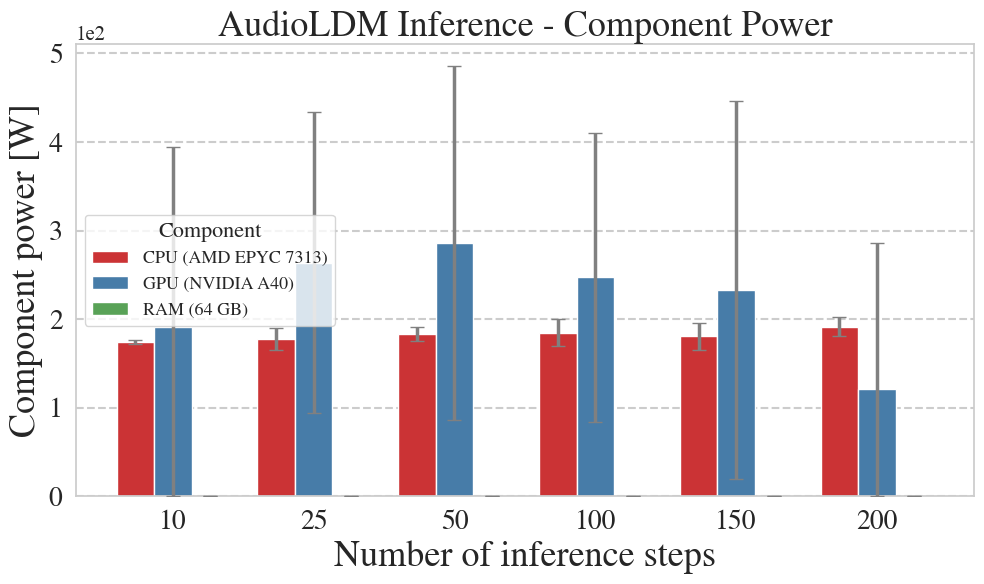

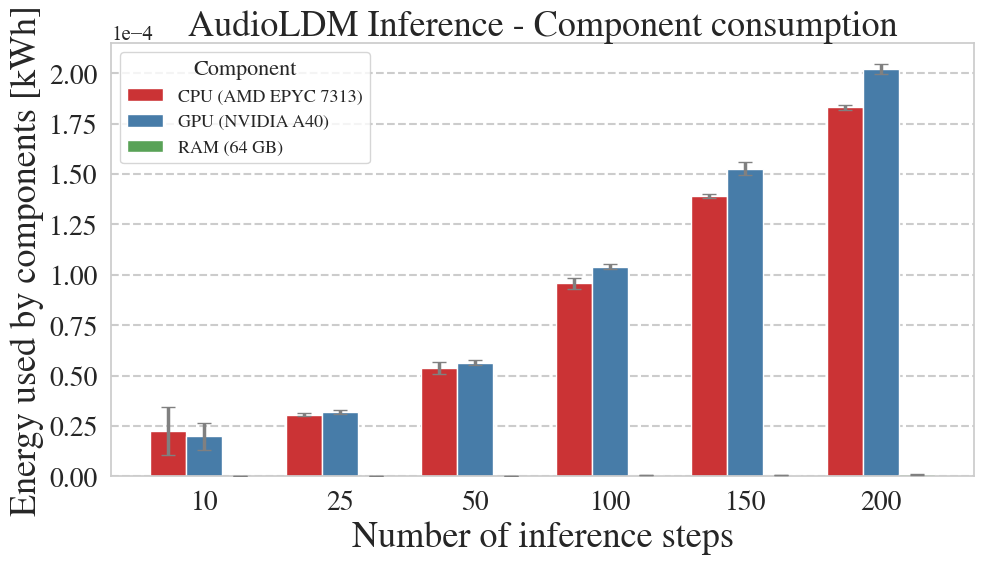

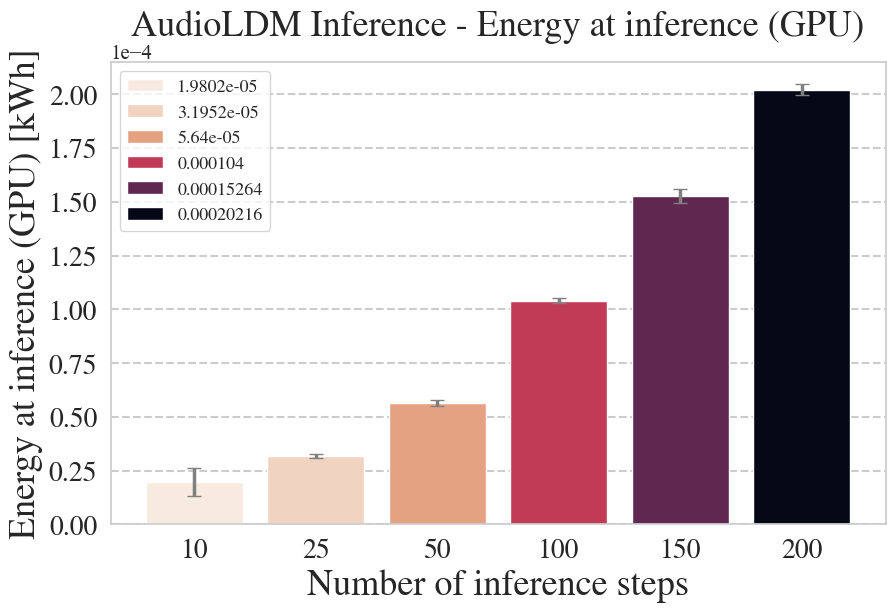

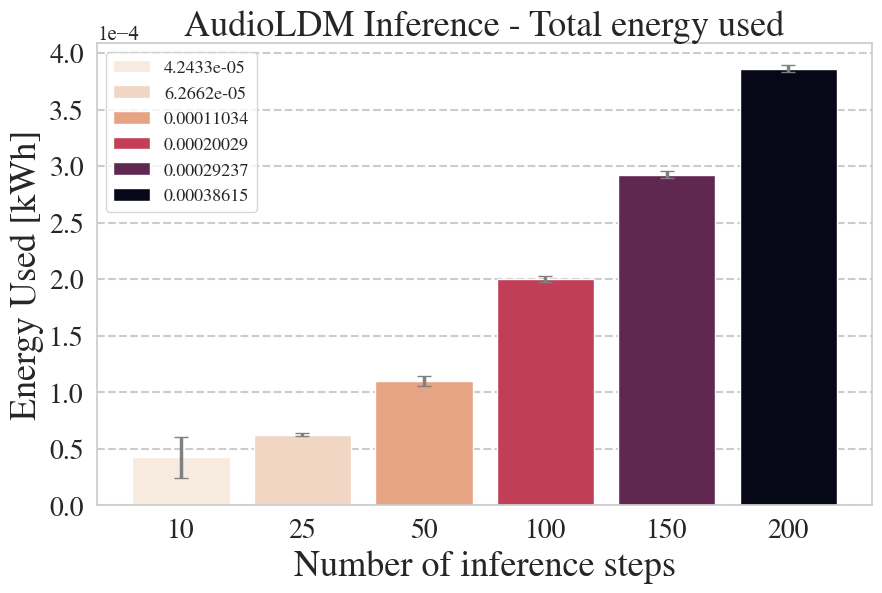

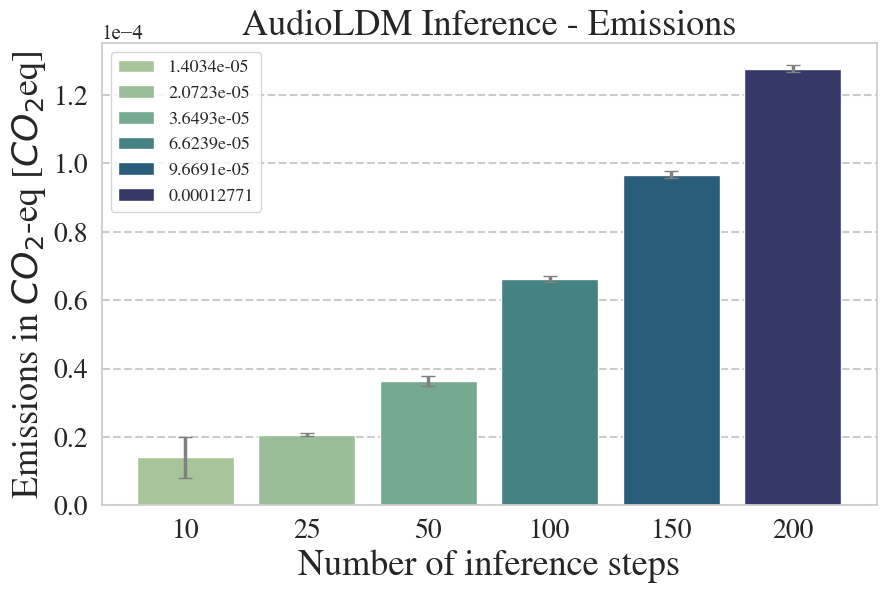

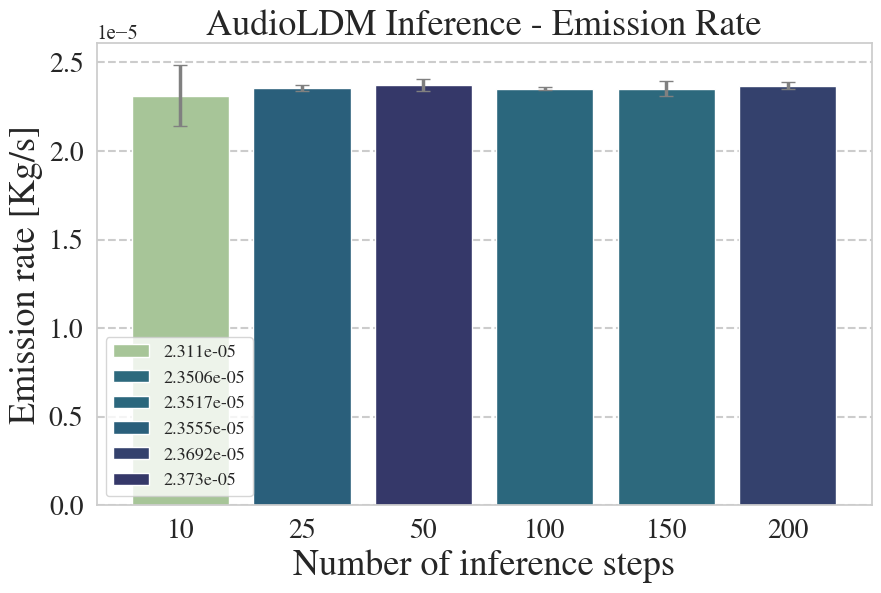

In [224]:
model = "AudioLDM" # model = "AudioLDM2" # model = "Make-an-Audio" # . . .

csvs = glob.glob(fr'{current_dir}\results\inference_steps\{model}\{model}-emissions-run*')
get_individual_plot(csvs, runs=5, option="summary", diffmodel=f'{model}')

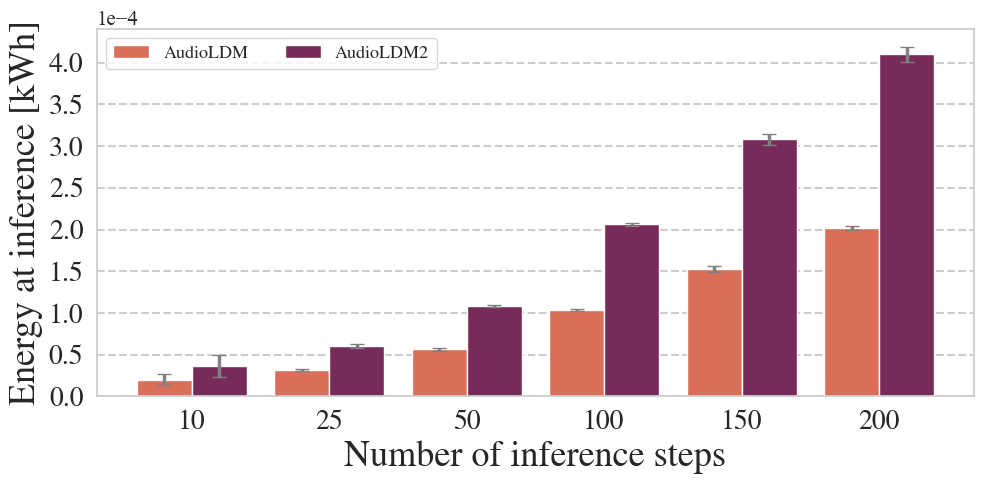

Plot saved!


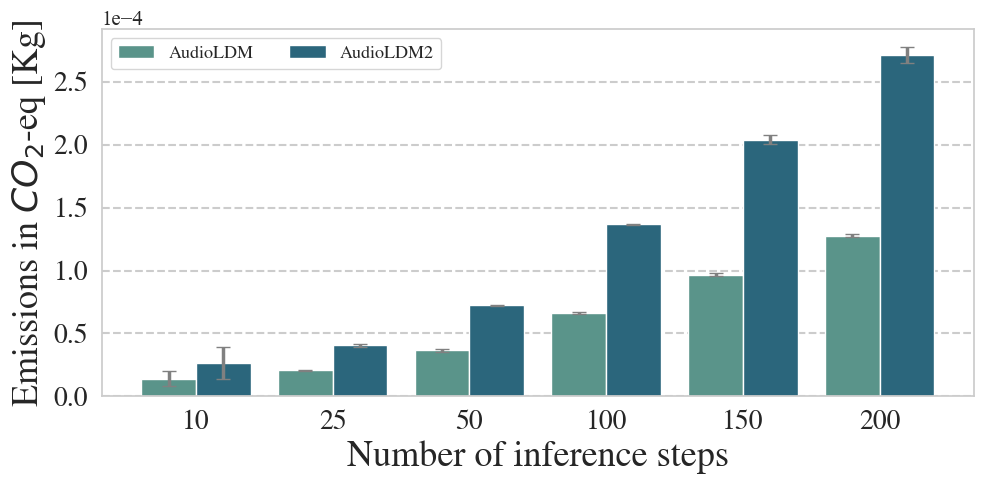

Plot saved!


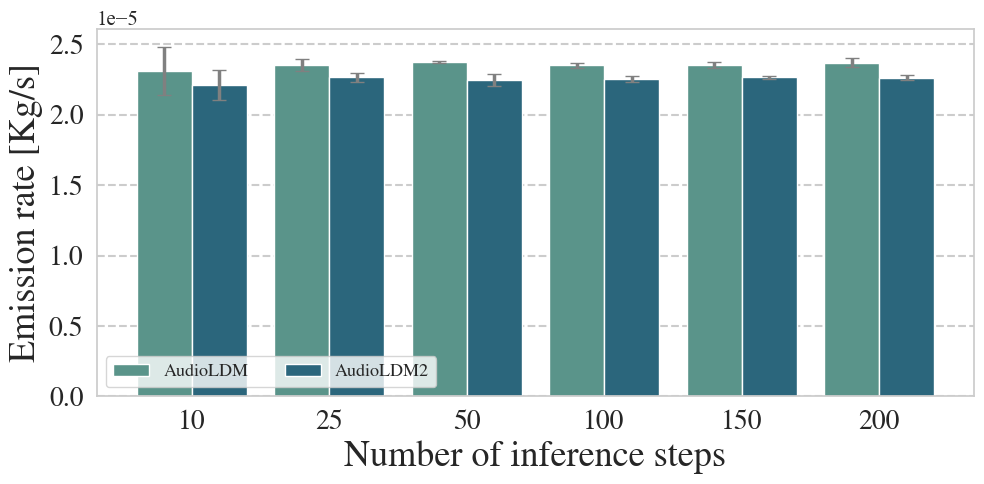

Plot saved!


In [225]:
model = ["AudioLDM", "AudioLDM2"]

# Prepare CSV files for model comparison
filtered_files = [[] for _ in range(len(model))]
for n, x in enumerate(model):
    pths = glob.glob(fr'{current_dir}\results\inference_steps\{x}\*.csv')
    filtered_files[n] = [
        file for file in pths
        if os.path.basename(file) in (f"{x}-mean.csv", f"{x}-std.csv")
    ]

# Compare diffusion models
compare_models(filtered_files, model, dictcolors, option="summary")

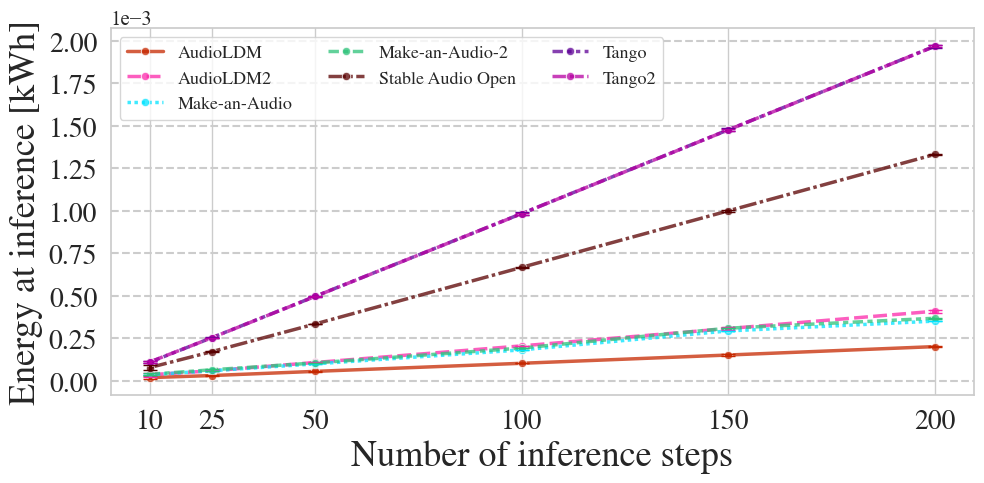

Plot saved!


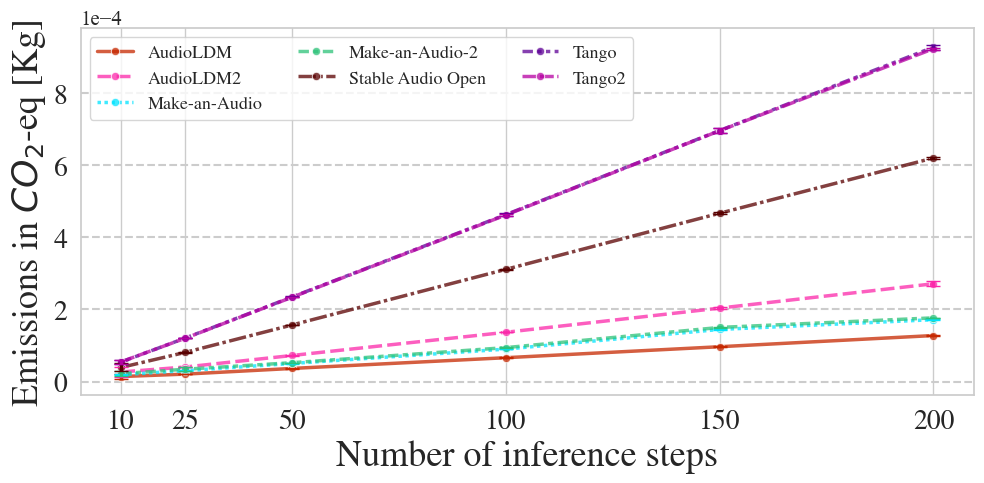

Plot saved!


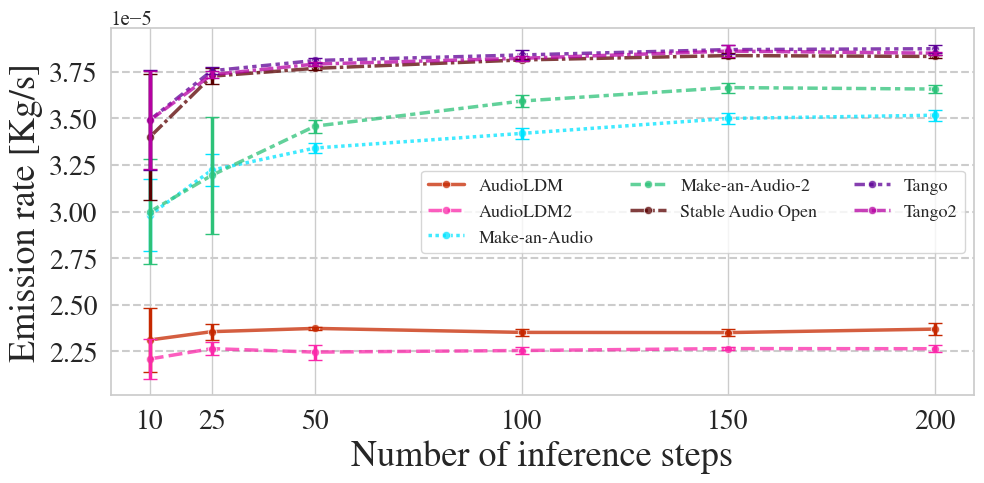

Plot saved!


In [226]:
model_list = ["AudioLDM", "AudioLDM2", "Make-an-Audio", "Make-an-Audio-2", "Stable Audio Open", "Tango", "Tango2"]

# Prepare CSV files for model comparison
filtered_files = [[] for _ in range(len(model_list))]
for n, x in enumerate(model_list):
    pths = glob.glob(fr'{current_dir}\results\inference_steps\{x}\*.csv')
    filtered_files[n] = [
        file for file in pths
        if os.path.basename(file) in (f"{x}-mean.csv", f"{x}-std.csv")
    ]

# Compare diffusion models
compare_models(filtered_files, model_list, dictcolors, option="summary")